Classical vs Quantum Comparison in Historical Fidelity Simulator

This script provides detailed comparisons between classical and quantum behaviors:
1. Time evolution characteristics
2. Response to temperature and coupling
3. Uncertainty relations and bounds
4. GPU-accelerated analysis for faster exploration

For theoretical background, see docs/research-proposal.md.

In [9]:
from typing import Dict, List, Any, Tuple
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import numpy.typing as npt

from historical_fidelity_simulator import (
    GeneralizedHistoricalSimulator,
    SimulationMode
)

### def setup_output_directory() -> Path:

Set up output directory for saving results.
    
    Returns:
        Path: Path to output directory
    

In [10]:
def setup_output_directory() -> Path:
    # Try different relative paths to find the output directory
    output_dir = Path('output')
    if not output_dir.exists():
        # If running from examples directory, go up one level
        output_dir = Path('..') / 'output'
    if not output_dir.exists():
        # If running from a subdirectory of examples, go up two levels
        output_dir = Path('../..') / 'output'
    
    # Create the output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Create a subdirectory for fidelity comparison results
    comparison_dir = output_dir / 'fidelity_comparison'
    comparison_dir.mkdir(exist_ok=True)
    
    print(f"Saving results to: {comparison_dir.absolute()}")
    return comparison_dir

In [11]:
def run_simulation_comparison(
    params: Dict[str, Any]
) -> Tuple[List[List[Dict[str, Any]]], List[List[Dict[str, Any]]]]:
    """Run both classical and quantum simulations for comparison.
    
    Args:
        params: Dictionary containing simulation parameters
        
    Returns:
        Tuple of (classical_results, quantum_results) where each is a list of results per temperature
    """
    temperatures = [0.5, 1.0, 2.0]
    classical_results = []
    quantum_results = []

    # Classical simulation for each temperature
    print("\nRunning classical simulations...")
    for T in temperatures:
        classical_sim = GeneralizedHistoricalSimulator(
            n_sites=params['n_sites'],
            coupling_strength=params['J'],
            field_strength=params['h'],
            temperature=T,
            hbar_h=params['hbar_h'],
            mode=SimulationMode.CLASSICAL,
            use_gpu=False  # Classical simulations should not use GPU
        )
        
        results = classical_sim.run_simulation(
            n_steps=params['n_steps_classical'],
            dt=params['dt'],
            measure_interval=params['measure_interval_classical']
        )
        classical_results.append(results)
    
    # Quantum simulation for each temperature
    print("\nRunning quantum simulations...")
    for T in temperatures:
        quantum_sim = GeneralizedHistoricalSimulator(
            n_sites=params['n_sites'],
            coupling_strength=params['J'],
            field_strength=params['h'],
            temperature=T,
            hbar_h=params['hbar_h'],
            mode=SimulationMode.QUANTUM,
            use_gpu=True  # Quantum simulations should use GPU
        )
        
        results = quantum_sim.run_simulation(
            n_steps=params['n_steps_quantum'],
            dt=params['dt'],
            measure_interval=params['measure_interval_quantum']
        )
        quantum_results.append(results)
    
    return classical_results, quantum_results

In [12]:
def compute_uncertainty_products(
    params: Dict[str, Any],
    coupling_range: npt.NDArray[np.float64],
    temperature_range: npt.NDArray[np.float64]
) -> Dict[str, npt.NDArray[np.float64]]:
    """Compute uncertainty products for classical and quantum modes.
    
    Args:
        params: Dictionary of simulation parameters
        coupling_range: Array of coupling strengths
        temperature_range: Array of temperatures
    
    Returns:
        Dictionary mapping mode to 2D array of uncertainty products
    """
    products = {
        'classical': np.zeros((len(temperature_range), len(coupling_range))),
        'quantum': np.zeros((len(temperature_range), len(coupling_range)))
    }
    
    print("\nComputing classical uncertainty products...")
    for i, T in enumerate(tqdm(temperature_range, desc="Classical mode")):
        for j, J in enumerate(coupling_range):
            sim = GeneralizedHistoricalSimulator(
                n_sites=params['n_sites'],
                coupling_strength=J,
                field_strength=params['h'],
                temperature=T,
                hbar_h=params['hbar_h'],
                mode=SimulationMode.CLASSICAL
            )
            
            results = sim.run_simulation(
                n_steps=params['n_steps_uncertainty_classical'],
                dt=params['dt'],
                measure_interval=params['measure_interval_uncertainty']
            )
            
            products['classical'][i, j] = results[-1]['bound']
    
    print("\nComputing quantum uncertainty products...")
    for i, T in enumerate(tqdm(temperature_range, desc="Quantum mode")):
        for j, J in enumerate(coupling_range):
            sim = GeneralizedHistoricalSimulator(
                n_sites=params['n_sites'],
                coupling_strength=J,
                field_strength=params['h'],
                temperature=T,
                hbar_h=params['hbar_h'],
                mode=SimulationMode.QUANTUM
            )
            
            results = sim.run_simulation(
                n_steps=params['n_steps_uncertainty_quantum'],
                dt=params['dt'],
                measure_interval=params['measure_interval_uncertainty']
            )
            
            products['quantum'][i, j] = results[-1]['bound']
    
    return products

In [13]:
def plot_evolution_comparison(
    classical_results: List[List[Dict[str, Any]]],
    quantum_results: List[List[Dict[str, Any]]],
    temperatures: List[float],
    output_dir: Path
) -> None:
    """Plot evolution comparison results.
    
    Args:
        classical_results: List of classical results for each temperature
        quantum_results: List of quantum results for each temperature
        temperatures: List of temperatures simulated
        output_dir: Directory to save plots
    """
    plt.figure(figsize=(15, 5))
    
    for i, T in enumerate(temperatures):
        plt.subplot(1, 3, i+1)
        
        # Extract results for this temperature
        times_classical = [step['time'] for step in classical_results[i]]
        fidelities_classical = [step['fidelity'] for step in classical_results[i]]
        bounds_classical = [step['bound'] for step in classical_results[i]]
        
        times_quantum = [step['time'] for step in quantum_results[i]]
        fidelities_quantum = [step['fidelity'] for step in quantum_results[i]]
        bounds_quantum = [step['bound'] for step in quantum_results[i]]
        
        # Add moving average for classical
        window = 20
        moving_avg = np.convolve(fidelities_classical, np.ones(window)/window, mode='valid')
        moving_avg_times = times_classical[window-1:]
        
        plt.plot(times_classical, fidelities_classical, 'b-', alpha=0.2, linewidth=0.5, label='Classical (Raw)')
        plt.plot(moving_avg_times, moving_avg, 'b-', linewidth=2.0, label='Classical (Avg)')
        plt.plot(times_quantum, fidelities_quantum, 'r-', linewidth=2.0, label='Quantum')
        plt.plot(times_classical, bounds_classical, 'b--', alpha=0.5, label='Classical Bound')
        plt.plot(times_quantum, bounds_quantum, 'r--', alpha=0.5, label='Quantum Bound')
        
        plt.xlabel('Time')
        plt.ylabel('Fidelity / Bound')
        plt.title(f'Evolution at T={T}')
        if i == 0:
            plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'evolution_comparison.png')
    plt.show()

In [14]:
def plot_uncertainty_products(
    uncertainty_products: Dict[str, npt.NDArray[np.float64]],
    coupling_range: npt.NDArray[np.float64],
    temperature_range: npt.NDArray[np.float64],
    output_dir: Path
) -> None:
    """Plot uncertainty product phase diagrams.
    
    Args:
        uncertainty_products: Dictionary of uncertainty products for each mode
        coupling_range: Array of coupling strengths
        temperature_range: Array of temperatures
        output_dir: Directory to save plots
    """
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.pcolormesh(coupling_range, temperature_range, uncertainty_products['classical'],
                   shading='auto')
    plt.colorbar(label='ℏ_h Bound')
    plt.xlabel('Coupling Strength (J)')
    plt.ylabel('Temperature (T)')
    plt.title('Classical Uncertainty Products')
    
    plt.subplot(1, 2, 2)
    plt.pcolormesh(coupling_range, temperature_range, uncertainty_products['quantum'],
                   shading='auto')
    plt.colorbar(label='ℏ_h Bound')
    plt.xlabel('Coupling Strength (J)')
    plt.ylabel('Temperature (T)')
    plt.title('Quantum Uncertainty Products')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'uncertainty_products.png')
    plt.show()
    
    # Plot differences
    differences = np.abs(uncertainty_products['quantum'] - uncertainty_products['classical'])
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(coupling_range, temperature_range, differences, shading='auto')
    plt.colorbar(label='|Quantum - Classical|')
    plt.xlabel('Coupling Strength (J)')
    plt.ylabel('Temperature (T)')
    plt.title('Quantum-Classical Difference in Uncertainty Products')
    plt.tight_layout()
    plt.savefig(output_dir / 'quantum_classical_differences.png')
    plt.show()
    
    # Print key observations
    print("\nKey Observations:")
    print(f"1. Maximum quantum-classical difference: {np.max(differences):.3f}")
    print(f"2. Average quantum-classical difference: {np.mean(differences):.3f}")
    print(f"3. Temperature with largest differences: T ≈ {temperature_range[np.argmax(np.mean(differences, axis=1))]:.2f}")
    print(f"4. Coupling with largest differences: J ≈ {coupling_range[np.argmax(np.mean(differences, axis=0))]:.2f}")

In [15]:
def main() -> None:
    # System parameters
    params = {
        'n_sites': 8,  # Small enough for quantum simulation
        'h': 0.1,      # External field strength
        'hbar_h': 0.1, # Information Planck constant
        'dt': 0.05,    # Time step
        'J': 1.0,      # Fixed coupling strength
        'T': 1.0,      # Temperature
        'n_steps_classical': 2000,
        'n_steps_quantum': 200,
        'measure_interval_classical': 10,
        'measure_interval_quantum': 2,
        'n_steps_uncertainty_classical': 1000,
        'n_steps_uncertainty_quantum': 100,
        'measure_interval_uncertainty': 50
    }
    
    # Temperature and coupling ranges
    temperatures = [0.5, 1.0, 2.0]  # For evolution comparison
    coupling_range = np.linspace(0.1, 3.0, 10)  # For uncertainty products
    temperature_range = np.linspace(0.5, 5.0, 10)  # For uncertainty products
    
    # Set up output directory
    output_dir = setup_output_directory()
    
    # Run evolution comparison
    classical_results, quantum_results = run_simulation_comparison(params)
    plot_evolution_comparison(classical_results, quantum_results, temperatures, output_dir)
    
    # Compute and plot uncertainty products
    uncertainty_products = compute_uncertainty_products(params, coupling_range, temperature_range)
    plot_uncertainty_products(uncertainty_products, coupling_range, temperature_range, output_dir)
    
    print("\nResults saved to:")
    print(f"- {(output_dir / 'evolution_comparison.png').absolute()}")
    print(f"- {(output_dir / 'uncertainty_products.png').absolute()}")
    print(f"- {(output_dir / 'quantum_classical_differences.png').absolute()}")

Saving results to: d:\PyProjects\historical-fidelity-simulator\examples\notebooks\04_classical_vs_quantum\..\..\output\fidelity_comparison

Running classical simulations...

Running quantum simulations...


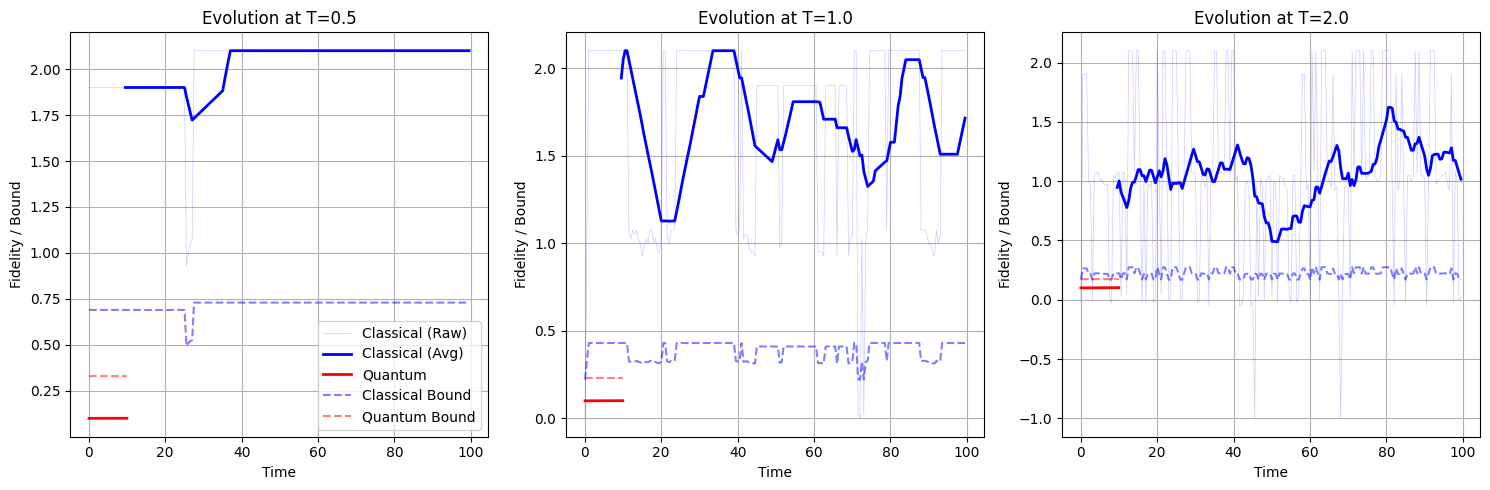


Computing classical uncertainty products...


Classical mode:   0%|          | 0/10 [00:00<?, ?it/s]d:\PyProjects\historical-fidelity-simulator\venv\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
d:\PyProjects\historical-fidelity-simulator\venv\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
Classical mode: 100%|██████████| 10/10 [01:17<00:00,  7.76s/it]



Computing quantum uncertainty products...


Quantum mode: 100%|██████████| 10/10 [01:19<00:00,  8.00s/it]


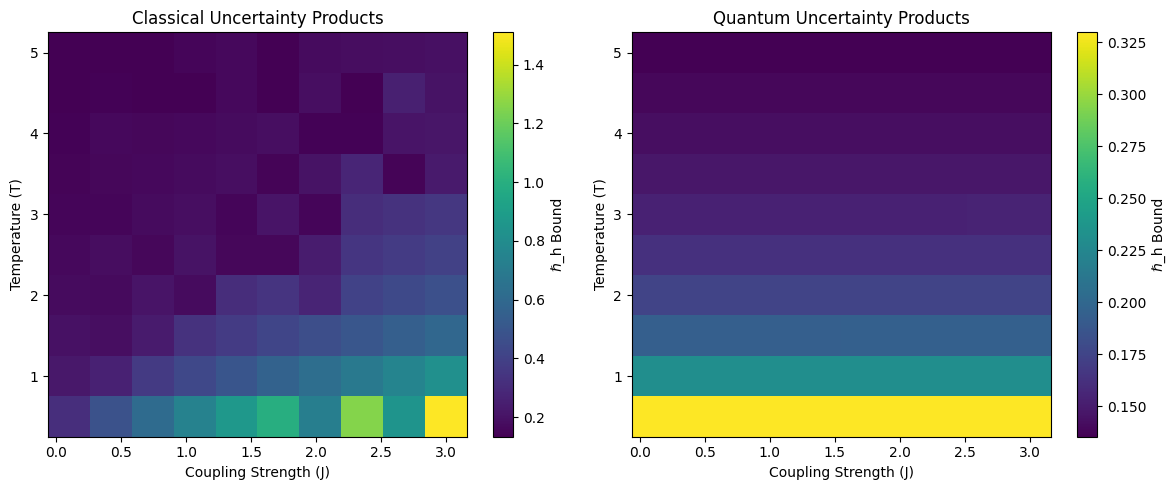

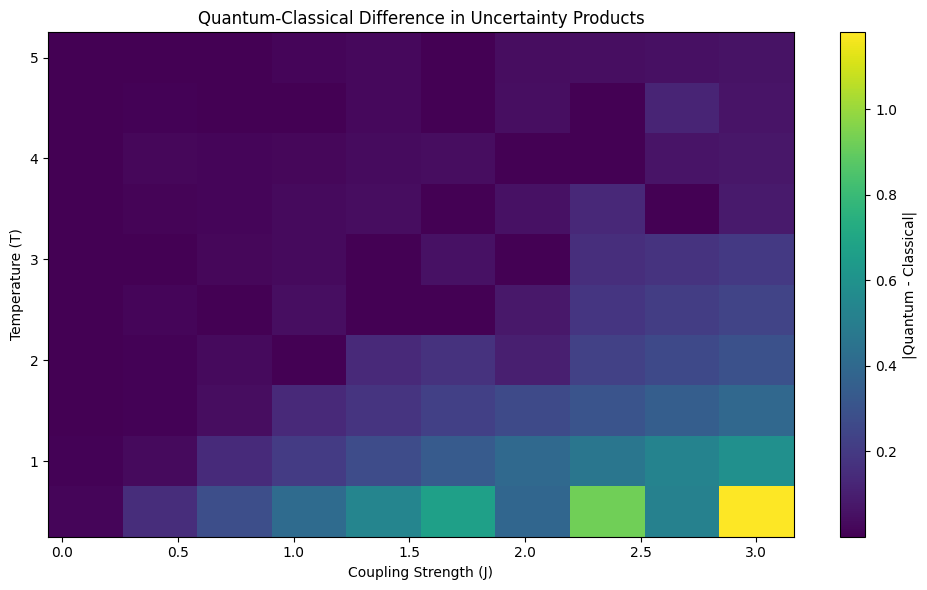


Key Observations:
1. Maximum quantum-classical difference: 1.180
2. Average quantum-classical difference: 0.137
3. Temperature with largest differences: T ≈ 0.50
4. Coupling with largest differences: J ≈ 3.00

Results saved to:
- d:\PyProjects\historical-fidelity-simulator\examples\notebooks\04_classical_vs_quantum\..\..\output\fidelity_comparison\evolution_comparison.png
- d:\PyProjects\historical-fidelity-simulator\examples\notebooks\04_classical_vs_quantum\..\..\output\fidelity_comparison\uncertainty_products.png
- d:\PyProjects\historical-fidelity-simulator\examples\notebooks\04_classical_vs_quantum\..\..\output\fidelity_comparison\quantum_classical_differences.png


In [16]:
# Run the main function
main()